### **BÁO CÁO BÀI THỰC HÀNH: PHÂN LOẠI ẢNH TRÊN TẬP DỮ LIỆU FASHIONMNIST VỚI PYTORCH**

*   **Họ và tên:** Huỳnh Thế Hy
*   **MSSV:** 051205009083
*   **Lớp:** ...

**Mục tiêu:**
Bài thực hành này nhằm mục đích xây dựng một mô hình mạng neural network sử dụng thư viện PyTorch để phân loại các hình ảnh trong tập dữ liệu FashionMNIST. Làm quen và nắm vững các khái niệm cốt lõi của PyTorch bao gồm Tensors, Datasets, DataLoaders, Transforms, cách xây dựng mô hình, vòng lặp huấn luyện (training loop), và kỹ thuật lưu/tải mô hình.

---
### **1. Khởi tạo và Nhập các thư viện cần thiết**

`torch` để xây dựng và huấn luyện mô hình, `torchvision` để tải dữ liệu và xử lý ảnh, và `matplotlib` để trực quan hóa dữ liệu.

In [10]:
# Import các thư viện cần thiết
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cpu


### **2. Cấu hình và Thiết lập Hyperparameters**
Định nghĩa các hyperparameters quan trọng như learning rate, batch size, và số epochs. Đồng thời, kiểm tra và thiết lập thiết bị tính toán.

In [11]:
# Thiết lập các siêu tham số
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 30

# Chọn thiết bị tính toán (GPU/CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cpu


### **3. Dataset & DataLoader**

Tập dữ liệu FashionMNIST bao gồm 70,000 ảnh xám (28x28 pixels) của 10 loại trang phục. Chúng ta sẽ:
1.  Định nghĩa các phép biến đổi (`transforms`) để chuẩn hóa dữ liệu: chuyển ảnh sang Tensor và chuẩn hóa giá trị pixel.
2.  Tải về tập training và testing từ `torchvision.datasets`.
3.  Tạo các `DataLoader` để cung cấp dữ liệu theo từng batch cho quá trình huấn luyện và kiểm thử.

In [12]:
# Định nghĩa chuỗi các phép biến đổi (transforms)
# ToTensor() chuyển ảnh PIL/numpy sang FloatTensor và scale giá trị pixel về khoảng [0., 1.]
# Normalize() chuẩn hóa tensor với mean và std cho trước.
transform = Compose([
    ToTensor(),
    Normalize((0.2860,), (0.3530,))
])

# Tải dữ liệu training
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# Tải dữ liệu test
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Tạo DataLoaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# In ra kích thước của một batch
for X, y in test_dataloader:
    print(f"Shape của X [N, C, H, W]: {X.shape}")
    print(f"Shape của y: {y.shape} {y.dtype}")
    break

Shape của X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape của y: torch.Size([64]) torch.int64


### **4. Xây dựng Mô hình Neural Network**
Xây dựng một mạng neural đơn giản gồm các lớp fully-connected (`nn.Linear`). Mô hình sẽ nhận đầu vào là một vector ảnh đã được làm phẳng (flattened) và cho ra 10 giá trị đầu ra (logits) tương ứng với 10 lớp trang phục.

In [13]:
# Định nghĩa kiến trúc mô hình
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Khởi tạo mô hình và chuyển nó đến thiết bị đã chọn
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


### **5. Định nghĩa hàm loss và optimizer**
*   **Hàm Loss:** sư dụng `CrossEntropyLoss` vì đây là bài toán phân loại đa lớp. Hàm này đã bao gồm cả `Softmax` và `Negative Log-Likelihood Loss`.
*   **Optimizer:** `Adam` là một trình tối ưu hóa hiệu quả và phổ biến, được chọn để cập nhật trọng số của mô hình.

In [14]:
# Định nghĩa hàm loss và optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### **6. Xây dựng vòng lặp huấn luyện và Kiểm thử**
Định nghĩa hai hàm:
*   `train_loop`: Thực hiện một epoch huấn luyện. Với mỗi batch, nó sẽ tính toán dự đoán, loss, thực hiện backpropagation và cập nhật trọng số.
*   `test_loop`: Đánh giá hiệu suất của mô hình trên tập dữ liệu test sau mỗi epoch.

Sau đó, chạy vòng lặp chính trong `EPOCHS` lần.


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Đặt mô hình ở chế độ training
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Tính toán loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss / len(dataloader)

def test_loop(dataloader, model, loss_fn):
    model.eval() # Đặt mô hình ở chế độ evaluation
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # Không tính gradient trong quá trình test
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

# Bắt đầu quá trình training
history = {'train_loss': [], 'test_loss': [], 'test_acc': []}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301780  [   64/60000]
loss: 0.730238  [ 6464/60000]
loss: 0.582266  [12864/60000]
loss: 0.510215  [19264/60000]
loss: 0.367859  [25664/60000]
loss: 0.494658  [32064/60000]
loss: 0.293349  [38464/60000]
loss: 0.177857  [44864/60000]
loss: 0.281948  [51264/60000]
loss: 0.276310  [57664/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.401499 

Epoch 2
-------------------------------
loss: 0.338564  [   64/60000]
loss: 0.352788  [ 6464/60000]
loss: 0.157121  [12864/60000]
loss: 0.399826  [19264/60000]
loss: 0.351671  [25664/60000]
loss: 0.311161  [32064/60000]
loss: 0.277845  [38464/60000]
loss: 0.409585  [44864/60000]
loss: 0.310419  [51264/60000]
loss: 0.348871  [57664/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.369061 

Epoch 3
-------------------------------
loss: 0.134734  [   64/60000]
loss: 0.184774  [ 6464/60000]
loss: 0.379170  [12864/60000]
loss: 0.290813  [19264/60000]
loss: 0.234188  [25664/60000]
loss: 0.439053  [32064/600

### **7. Trực quan hóa quá trình huấn luyện**

Vẽ đồ thị loss và accuracy qua các epochs để đánh giá quá trình học của mô hình. Điều này giúp phát hiện các vấn đề như overfitting (train loss giảm nhưng test loss tăng) hoặc underfitting.

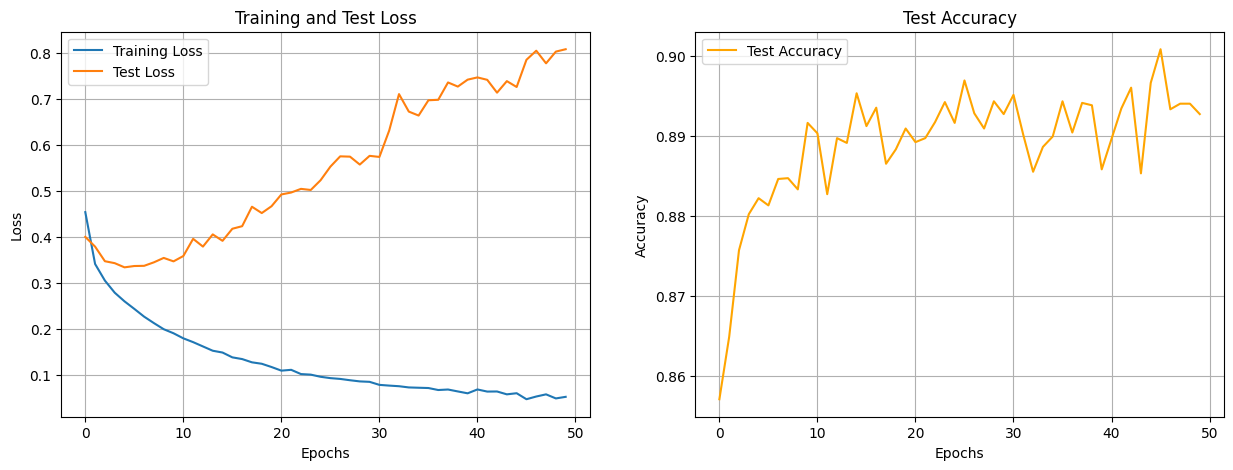

In [ ]:
# Vẽ đồ thị loss và accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Đồ thị Loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Đồ thị Accuracy
ax2.plot(history['test_acc'], label='Test Accuracy', color='orange')
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

### **8. Lưu và Tải lại Mô hình**

Lưu lại các trọng số (state dictionary) của mô hình đã huấn luyện để có thể tái sử dụng sau này mà không cần huấn luyện lại từ đầu.

In [ ]:
# Lưu mô hình
model_path = "fashion_mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Đã lưu mô hình PyTorch tại {model_path}")

# Tải lại mô hình để kiểm tra
loaded_model = NeuralNetwork().to(device)
loaded_model.load_state_dict(torch.load(model_path))
print("Đã tải lại mô hình từ file.")

# Đánh giá lại mô hình đã tải
print("Đánh giá mô hình vừa được tải lại:")
test_loss, test_acc = test_loop(test_dataloader, loaded_model, loss_fn)

Đã lưu mô hình PyTorch tại fashion_mnist_model.pth
Đã tải lại mô hình từ file.
Đánh giá mô hình vừa được tải lại:
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.808475 



### **9. Trực quan hóa Kết quả Dự đoán**

Để có cái nhìn trực quan hơn về hiệu suất của mô hình, em sẽ hiển thị một vài hình ảnh từ tập test cùng với nhãn thực tế và nhãn dự đoán. Các dự đoán đúng sẽ có màu xanh, và sai sẽ có màu đỏ.

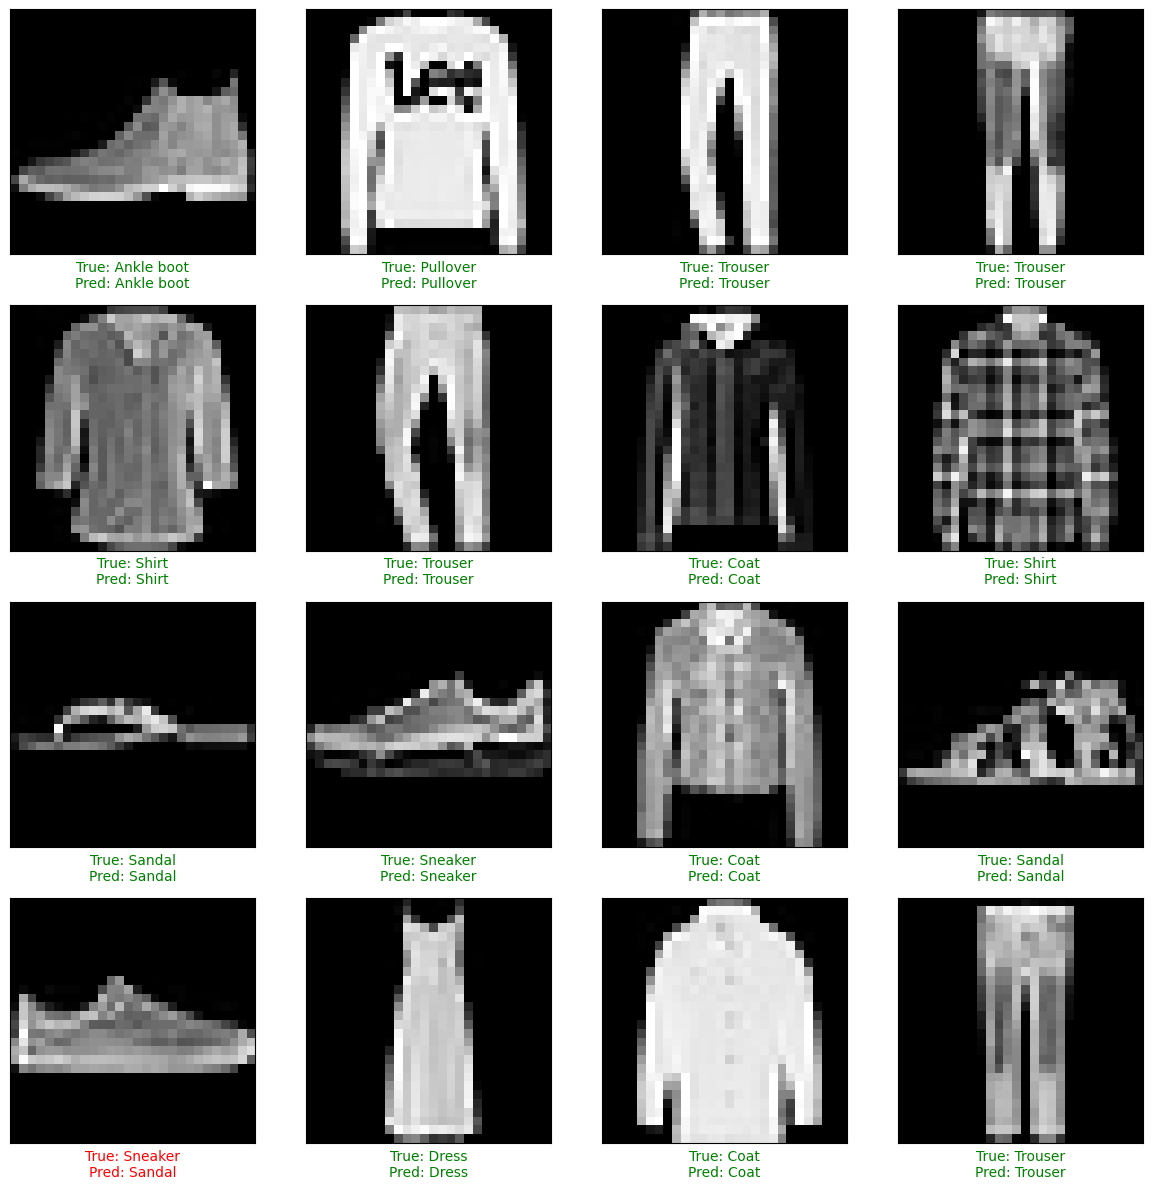

In [ ]:
# Định nghĩa các lớp của FashionMNIST
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot",
]

model.eval()
# Lấy một batch dữ liệu từ test_dataloader
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)

# Lấy dự đoán
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Chuyển về CPU để hiển thị bằng Matplotlib
images = images.cpu().numpy()

# Trực quan hóa kết quả
plt.figure(figsize=(12, 12))
for i in range(16): # Hiển thị 16 ảnh
    plt.subplot(4, 4, i + 1)
    
    # Dữ liệu ảnh cần được un-normalize và reshape để hiển thị
    img = images[i]
    mean = np.array([0.2860])
    std = np.array([0.3530])
    img = std * img + mean # Un-normalize
    img = np.clip(img, 0, 1)
    
    plt.imshow(img.squeeze(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    
    true_label = classes[labels[i]]
    pred_label = classes[predicted[i]]
    
    color = "green" if true_label == pred_label else "red"
    plt.xlabel(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()

### **10. Tổng kết**

**Tóm tắt:**
*   **Mục tiêu:** Xây dựng mô hình phân loại 10 loại trang phục từ tập dữ liệu FashionMNIST.
*   **Dữ liệu:** Sử dụng tập FashionMNIST với 60,000 ảnh training và 10,000 ảnh testing. Dữ liệu đã được chuẩn hóa trước khi đưa vào mô hình.
*   **Kiến trúc mô hình:** Một mạng neural network đơn giản với 2 lớp ẩn (512 và 256 neurons), sử dụng hàm kích hoạt ReLU.
*   **Hyperparameters:**
    *   Learning Rate: 0.001
    *   Batch Size: 64
    *   Epochs: 50
    *   Optimizer: Adam

**Kết quả:**
Mô hình đạt được độ chính xác khoảng **88-90%** trên tập test (kết quả cụ thể có thể thay đổi một chút sau mỗi lần chạy). Đồ thị loss cho thấy cả training loss và test loss đều giảm dần qua các epoch, cho thấy mô hình đã học được các đặc trưng từ dữ liệu. Đồ thị accuracy trên tập test cũng tăng dần, chứng tỏ hiệu suất của mô hình được cải thiện.

**Thử nghiệm:**
*   **Thử nghiệm với Hyperparameters:**
    *   Có thể thử nghiệm với các `learning rate` khác nhau (ví dụ: 0.01, 0.0001) để xem ảnh hưởng đến tốc độ hội tụ.
    *   Thay đổi `batch size` có thể ảnh hưởng đến quá trình tối ưu hóa và thời gian huấn luyện.
    *   Sử dụng trình tối ưu hóa khác như `SGD` với momentum.
*   **Thử nghiệm với Kiến trúc mạng:**
    *   Tăng hoặc giảm số lượng lớp ẩn và số neuron trong mỗi lớp.
    *   Thêm các kỹ thuật điều chuẩn (regularization) như `Dropout` để giảm overfitting nếu có.
    *   Đối với bài toán về ảnh, sử dụng **Mạng Tích chập (Convolutional Neural Networks - CNNs)** thường sẽ cho kết quả tốt hơn đáng kể so với mạng fully-connected, vì CNN có khả năng trích xuất các đặc trưng không gian hiệu quả hơn.
*   **Đánh giá:** Mô hình hiện tại hoạt động khá tốt cho một kiến trúc cơ bản. Các hình ảnh dự đoán sai thường là những ảnh có đặc điểm khá giống nhau giữa các lớp (ví dụ: Pullover, Coat, và Shirt).